In [9]:
from population import evolve_classifier, heritage
from operations import ReprFromMatrix
import sklearn, sklearn.datasets
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import os


from skimage import img_as_int, img_as_float
from skimage.io import imread
from skimage.transform import rescale, rotate

In [2]:
iris = sklearn.datasets.load_iris(return_X_y=True)
digits = sklearn.datasets.load_digits(return_X_y=True)

def load_leaves(max_dim=91):
    leaves_root = '../Kaggle - leaves classification/input/'
    train = pd.read_csv(leaves_root+'train.csv', index_col='id')
    label_encoder = LabelEncoder().fit(train.species)
    labels = label_encoder.transform(train.species)
    classes = list(label_encoder.classes_)
    
    #channels = 1
    images = np.empty((len(train), max_dim, max_dim))
    for i, idee in enumerate(train.index):
        filename = os.path.join(leaves_root, 'images', str(idee) + '.jpg')
        img = imread(filename)
        max_ax = max((0, 1), key=lambda i: img.shape[i])
        # Scale both axes so the image's largest dimension is max_dim
        scale = max_dim / float(img.shape[max_ax])
        img = rescale(img, scale)
        #TODO center
        images[i,0:img.shape[0],0:img.shape[1]] = img
    images = np.expand_dims(images, axis=3)
    return images, labels#train.species

leaves = load_leaves(29)
    
#datasets = [iris, digits, leaves]
#datasets = [iris, digits]
datasets = [leaves]

In [3]:
leaves[0].shape

(990, 29, 29, 1)

In [4]:
from sklearn.model_selection import train_test_split


world_shape = (len(datasets)*10, 10)

def classification_dataset_to_gradient(dataset, parts=4):
    data, target = dataset
    if data.dtype == 'float64':
        data = data.astype('float32')
    target = target.astype('int32')
    n_classes = len(np.unique(target))
    
    X_train_grad, y_train_grad, X_test_grad, y_test_grad = list(), list(), list(), list()
    for p in range(parts):
        r = train_test_split(data, target, stratify=target)
        #print(r[0].dtype, r[1].dtype, r[2].dtype, r[3].dtype)
        X_train_grad.append(r[0])
        X_test_grad.append(r[1])
        y_train_grad.append(r[2])
        y_test_grad.append(r[3])
    
    n_classes_grad = [n_classes for i in range(parts)]
    return X_train_grad, y_train_grad, X_test_grad, y_test_grad, n_classes_grad

gradients = None
for ds in datasets:
    more_gradients = classification_dataset_to_gradient(ds)
    if gradients is None:
        gradients = more_gradients
    else:
        gradients = [g0 + g1 for g0, g1 in zip(gradients, more_gradients)]


X_train_grad, y_train_grad, X_test_grad, y_test_grad, n_classes_grad = gradients
steps_mask = np.fromfunction(lambda i,j: (j+10)*50, world_shape, dtype='int32')
batch_mask = np.zeros(world_shape, dtype='int32')#np.fromfunction(lambda i,j: (i%2+1)*250, world_shape, dtype='int32')


In [5]:
import pickle

def saveState(name, data):
    with open(name+'.pickle', 'wb') as out:
        pickle.dump(data, out)

def loadState(name):
    return pickle.load(open(name+".pickle", 'rb'))

In [7]:
passports = []
'''
from farm import MassFarming

massive_farm = MassFarming(X_train_grad, y_train_grad, X_test_grad, y_test_grad, n_classes_grad, 
                      steps_mask=steps_mask, batch_mask=batch_mask, passports=passports,
                      world_shape=world_shape)

massive_farm.evolve(20)

world, fitness = massive_farm.world, massive_farm.fitness
'''
evolve_iter = evolve_classifier(X_train_grad, y_train_grad, X_test_grad, y_test_grad, n_classes_grad, 
                  passports=passports,
                  steps_mask=steps_mask, batch_mask=batch_mask, world_shape=world_shape)

for i in range(10):
    world, fitness = next(evolve_iter)
    saveState('world', world)
    saveState('fitness', fitness)
    saveState('passports', passports)

GENERATION: 0
Eval genome:
[('conv2d_in_plane', (), {'stride': 1, 'kernel_size': 9, 'padding': 'SAME'}), ('batch_norm', (), {'center': False, 'scale': True}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('l2_normalize', (), {'dim': 0}), ('avg_pool2d', (), {'stride': [3, 3], 'kernel_size': [8, 8], 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.0120967741935 7.5255982875823975
Eval genome:
[('lrn', (), {'depth_radius': 4}), ('fully_connected', (), {'num_outputs': 319}), ('relu', (), {}), ('conv2d', (), {'stride': 7, 'kernel_size': 5, 'num_outputs': 24, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [9, 9], 'padding': 'SAME'}), ('flatten', (), {})]
Acc/Time 0.0201612903226 82.49297523498535
Eval genome:
[('elu', (), {}), ('tanh', (), {}), ('lrn', (), {'depth_radius': 3}), ('conv2d', (), {'stride': 9, 'kernel_size': 4, 'num_outputs': 34, 'padding': 'SAME'})]
Acc/Time 0.068

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0161290322581 2.702162742614746
Eval genome:
[('fully_connected', (), {'num_outputs': 419}), ('tanh', (), {}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('l2_normalize', (), {'dim': 2}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('lrn', (), {'depth_radius': 4}), ('tanh', (), {})]
Acc/Time 0.391129032258 7.942045450210571
Eval genome:
[('dropout', (0.4763214894378988,), {}), ('lrn', (), {'depth_radius': 2}), ('dropout', (0.8678556753698589,), {}), ('batch_norm', (), {'center': True, 'scale': False})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.471774193548 4.76263689994812
Eval genome:
[('conv2d_transpose', (), {'stride': 10, 'kernel_size': 6, 'num_outputs': 38, 'padding': 'SAME'}), ('tanh', (), {}), ('elu', (), {}), ('avg_pool2d', (), {'stride': [10, 10], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [2, 2], 'kernel_size': [6, 6], 'padding': 'SAME'})]
Individual died from exhaustion
Eval genome:
[('elu', (), {}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 8, 'ke

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Operation construction failed: <class 'IndexError'> conv2d_transpose [  6.52365208e+307   3.69641518e+307   1.31594770e+308   1.03254402e+307]
--------------
skipping layer


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.403225806452 3.142263412475586
Eval genome:
[('softsign', (), {}), ('fully_connected', (), {'num_outputs': 100}), ('conv2d', (), {'stride': 10, 'kernel_size': 2, 'num_outputs': 30, 'padding': 'SAME'}), ('l2_normalize', (), {'dim': 0}), ('conv2d_transpose', (), {'stride': 2, 'kernel_size': 5, 'num_outputs': 20, 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.00806451612903 17.273662567138672
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('softplus', (), {}), ('lrn', (), {'depth_radius': 1}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('relu', (), {}), ('relu6', (), {})]
Acc/Time 0.0161290322581 1.63079833984375
Eval genome:
[('flatten', (), {}), ('layer_norm', (), {'center': False, 'scale': False}), ('dropout', (0.4318283480656675,), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('softsign', (), {}), ('layer_norm', (), {'center': True, 'scale': 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.375 11.648442029953003
Eval genome:
[('sigmoid', (), {}), ('batch_norm', (), {'center': False, 'scale': True}), ('flatten', (), {}), ('sigmoid', (), {})]
Acc/Time 0.237903225806 3.1035141944885254
Eval genome:
[('lrn', (), {'depth_radius': 2}), ('softplus', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('sigmoid', (), {}), ('max_pool2d', (), {'stride': [1, 1], 'kernel_size': [4, 4], 'padding': 'SAME'})]
Acc/Time 0.0725806451613 3.593709945678711
Eval genome:
[('relu', (), {}), ('unit_norm', (), {'dim': 1}), ('softsign', (), {}), ('elu', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.362903225806 2.6713507175445557
Eval genome:
[('avg_pool2d', (), {'stride': [9, 9], 'kernel_size': [2, 2], 'padding': 'SAME'}), ('layer_norm', (), {'center': False, 'scale': True}), ('avg_pool2d', (), {'stride': [5, 5], 'kernel_size': [3, 3], 'padding': 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0282258064516 5.820260047912598
Eval genome:
[('conv2d', (), {'stride': 3, 'kernel_size': 6, 'num_outputs': 57, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 10, 'kernel_size': 3, 'padding': 'SAME'}), ('relu', (), {}), ('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 10})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.129032258065 18.211801767349243
Eval genome:
[('softplus', (), {}), ('tanh', (), {}), ('dropout', (0.4382588287773054,), {}), ('elu', (), {}), ('softsign', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.00806451612903 5.6005353927612305
GENERATION: 1


/home/jason/.local/lib/python3.5/site-packages/scipy/sparse/compressed.py:344: RuntimeWarning: overflow encountered in add
  return self.todense() + other


Eval genome:
[('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('layer_norm', (), {'center': False, 'scale': False}), ('relu', (), {}), ('l2_normalize', (), {'dim': 2})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.0725806451613 1.8980226516723633
Eval genome:
[('conv2d', (), {'stride': 3, 'kernel_size': 6, 'num_outputs': 57, 'padding': 'SAME'}), ('dropout', (0.031000829554155604,), {}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 11, 'padding': 'SAME'}), ('unit_norm', (), {'dim': 1}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 11, 'padding': 'SAME'})]
Acc/Time 0.0161290322581 31.15721821784973
Eval genome:
[('fully_connected', (), {'num_outputs': 375}), ('fully_connected', (), {'num_outputs': 3125}), ('lrn', (), {'depth_radius': 2}), ('relu', (), {}), ('avg_pool2d', (), {'stride': [1, 1], 'kernel_size': [4, 4], 'padding': 'SAME'})]
Bad retur

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('softsign', (), {}), ('l2_normalize', (), {'dim': 1}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('lrn', (), {'depth_radius': 4}), ('conv2d_in_plane', (), {'stride': 6, 'kernel_size': 1, 'padding': 'SAME'})]
Acc/Time 0.0887096774194 12.386697053909302
Eval genome:
[('fully_connected', (), {'num_outputs': 291}), ('unit_norm', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 5670}), ('fully_connected', (), {'num_outputs': 5312}), ('unit_norm', (), {'dim': 1})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 4467392
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_6 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [4467392,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_6', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/us

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died from exhaustion
Eval genome:
[('max_pool2d', (), {'stride': [11, 11], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('separable_convolution2d', (), {'stride': 1, 'kernel_size': 6, 'num_outputs': 11, 'depth_multiplier': 11, 'padding': 'SAME'}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('separable_convolution2d', (), {'stride': 8, 'kernel_size': 1, 'num_outputs': 121, 'depth_multiplier': 11, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [8, 8], 'kernel_size': [2, 2], 'padding': 'SAME'})]
Acc/Time 0.108870967742 6.953853607177734
Eval genome:
[('conv2d_transpose', (), {'stride': 7, 'kernel_size': 10, 'num_outputs': 59, 'padding': 'SAME'}), ('lrn', (), {'depth_radius': 3}), ('max_pool2d', (), {'stride': [10, 10], 'kernel_size': [10, 10], 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 2816}), ('softplus', (), {})]
Individual died from exhaustion
Eval genome:
[('max_pool2d', (), {'stride': [10, 10], 'kernel_size': [10, 10], 'padding': 'SAME'}), ('max_p

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.00806451612903 1243.6254999637604
Eval genome:
[('fully_connected', (), {'num_outputs': 419}), ('tanh', (), {}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jas

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('layer_norm', (), {'center': True, 'scale': True}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('l2_normalize', (), {'dim': 1}), ('sigmoid', (), {})]
Acc/Time 0.0120967741935 13.988027811050415
Eval genome:
[('conv2d', (), {'stride': 6, 'kernel_size': 2, 'num_outputs': 21, 'padding': 'SAME'}), ('batch_norm', (), {'center': False, 'scale': True}), ('relu6', (), {}), ('sigmoid', (), {}), ('relu6', (), {}), ('sigmoid', (), {})]
Acc/Time 0.0120967741935 6.789903402328491
Eval genome:
[('unit_norm', (), {'dim': 0}), ('batch_norm', (), {'center': False, 'scale': True}), ('tanh', (), {}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.383064516129 6.718223810195923
Eval genome:
[('unit_norm', (), {'dim': 0}), ('batch_norm', (), {'center': False, 'scale': True}), ('fully_connected', (), {'num_outputs': 1643}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Indi

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0282258064516 4.021398067474365
Eval genome:
[('conv2d_transpose', (), {'stride': 3, 'kernel_size': 1, 'num_outputs': 32, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [2, 2], 'padding': 'SAME'}), ('avg_pool2d', (), {'stride': [6, 6], 'kernel_size': [5, 5], 'padding': 'SAME'}), ('unit_norm', (), {'dim': 0}), ('relu', (), {}), ('relu6', (), {})]
Acc/Time 0.0161290322581 48.6622793674469
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('max_pool2d', (), {'stride': [2, 2], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('dropout', (0.4318283480656675,), {}), ('sigmoid', (), {}), ('conv2d', (), {'stride': 7, 'kernel_size': 7, 'num_outputs': 47, 'padding': 'SAME'})]
Acc/Time 0.0887096774194 4.095014572143555
Eval genome:
[('lrn', (), {'depth_radius': 2}), ('fully_connected', (), {'num_outputs': 207}), ('batch_norm', (), {'center': True, 'scale': True}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [6, 6], 'padding': 'SAME'}), 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('separable_convolution2d', (), {'stride': 10, 'kernel_size': 1, 'num_outputs': 4, 'depth_multiplier': 4, 'padding': 'SAME'}), ('softplus', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('tanh', (), {}), ('flatten', (), {})]
Acc/Time 0.0524193548387 4.099466562271118
Eval genome:
[('layer_norm', (), {'center': True, 'scale': False}), ('softplus', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Acc/Time 0.233870967742 7.288272380828857
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('l2_normalize', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 6215}), ('lrn', (), {'depth_radius': 3})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5226815
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Const[dtype=DT_FLOAT, value=Tensor

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0403225806452 4.36741042137146
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 6, 'kernel_size': 1, 'num_outputs': 46, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': False})]
Individual died from exhaustion
Eval genome:
[('elu', (), {}), ('batch_norm', (), {'center': False, 'scale': False}), ('lrn', (), {'depth_radius': 3}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'}), ('tanh', (), {})]
Acc/Time 0.33064516129 13.316399574279785
Eval genome:
[('conv2d_in_plane', (), {'stride': 4, 'kernel_size': 3, 'padding': 'SAME'}), ('softplus', (), {}), ('flatten', (), {})]
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  3.99483044e+307   6.02849529e+307   1.79769313e+308   8.80545229e+307]
rank of shape must be at least 4 not: 2
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  1.7884

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('relu', (), {}), ('elu', (), {}), ('l2_normalize', (), {'dim': 2}), ('conv2d', (), {'stride': 7, 'kernel_size': 3, 'num_outputs': 6, 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.161290322581 3.146399974822998
Eval genome:
[('conv2d', (), {'stride': 4, 'kernel_size': 8, 'num_outputs': 38, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [4, 4], 'padding': 'SAME'}), ('elu', (), {}), ('elu', (), {}), ('fully_connected', (), {'num_outputs': 154})]
Acc/Time 0.33064516129 10.11638593673706
Eval genome:
[('softsign', (), {}), ('conv2d_in_plane', (), {'stride': 10, 'kernel_size': 3, 'padding': 'SAME'}), ('relu', (), {}), ('fully_connected', (), {'num_outputs': 1}), ('flatten', (), {})]
Acc/Time 0.133064516129 3.9147915840148926
Eval genome:
[('fully_connected', (), {'num_outputs': 375}), ('fully_connected', (), {'num_outp

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('l2_normalize', (), {'dim': 2}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('lrn', (), {'depth_radius': 4}), ('batch_norm', (), {'center': True, 'scale': True})]
Acc/Time 0.45564516129 21.5407235622406
Eval genome:
[('relu6', (), {}), ('relu6', (), {}), ('separable_convolution2d', (), {'stride': 11, 'kernel_size': 11, 'num_outputs': 11, 'depth_multiplier': 11, 'padding': 'VALID'}), ('sigmoid', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.0967741935484 4.5242860317230225
Eval genome:
[('fully_connected', (), {'num_outputs': 291}), ('unit_norm', (), {'dim': 1}), ('batch_norm', (), {'center': False, 'scale': True}), ('flatten', (), {}), ('sigmoid', (), {})]
Individual died from exhaustion
Eval genome:
[('conv2d_transpose', (), {'stride': 7, 'kernel_size': 10, 'num_outputs': 59, 'padding': 'SAME'}), ('lrn', (), {'depth_radius': 3}), ('conv2d_in

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.342741935484 2533.708213329315
Eval genome:
[('fully_connected', (), {'num_outputs': 419}), ('tanh', (), {}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('softsign', (), {}), ('sigmoid', (), {}), ('fully_connected', (), {'num_outputs': 1643}), ('conv2d_in_plane', (), {'stride': 9, 'kernel_size': 5, 'padding': 'SAME'})]
Individual died from exhaustion
Eval genome:
[('unit_norm', (), {'dim': 0}), ('batch_norm', (), {'center': False, 'scale': True}), ('fully_connected', (), {'num_outputs': 1643}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died from exhaustion
Eval genome:
[('relu', (), {}), ('unit_norm', (), {'dim': 2}), ('unit_norm', (), {'dim': 2}), ('l2_normalize', (), {'dim': 1}), ('unit_norm', (), {'dim': 2}), ('l2_normalize', (), {'dim': 1})]
Acc/Time 0.0201612903226 2.0425357818603516
Eval genome:
[('tanh', (), {}), ('max_pool2d', (), {'stride': [8, 8], 'kernel_size': [2, 2], 'padding': 'SAME'}), ('sigmoid', (), {}), ('unit_norm', (), {'dim': 0}), ('lrn', (), {'depth_radius': 4}), ('avg_pool2d', (), {'stride': [9, 9], 'kernel_size': [1, 1], 'padding': 'SAME'})]
Acc/Time 0.008064516

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('lrn', (), {'depth_radius': 1}), ('sigmoid', (), {}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 9, 'padding': 'SAME'}), ('relu', (), {})]
Acc/Time 0.120967741935 285.90713453292847
Eval genome:
[('conv2d_transpose', (), {'stride': 3, 'kernel_size': 1, 'num_outputs': 32, 'padding': 'SAME'}), ('separable_convolution2d', (), {'stride': 8, 'kernel_size': 11, 'num_outputs': 352, 'depth_multiplier': 11, 'padding': 'SAME'}), ('relu', (), {}), ('unit_norm', (), {'dim': 0}), ('l2_normalize', (), {'dim': 1}), ('sigmoid', (), {})]
Acc/Time 0.00806451612903 1634.462316274643
Eval genome:
[('conv2d_transpose', (), {'stride': 3, 'kernel_size': 1, 'num_outputs': 32, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [2, 2], 'padding': 'SAME'}), ('avg_pool2d', (), {'stride': [6, 6], 'kernel_size': [5, 5], 'padding': 'SAME'}), ('unit_norm', (), {'dim': 0}), ('l2_normalize', (), {'dim': 1}), ('sigmoid', (), {})]
Acc/Time 0.0120967741935 48.499948263

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual was too big
Eval genome:
[('elu', (), {}), ('elu', (), {}), ('relu6', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.395161290323 3.917555809020996
Eval genome:
[('conv2d_transpose', (), {'stride': 1, 'kernel_size': 2, 'num_outputs': 18, 'padding': 'SAME'}), ('sigmoid', (), {}), ('fully_connected', (), {'num_outputs': 1845}), ('fully_connected', (), {'num_outputs': 1997}), ('l2_normalize', (), {'dim': 2}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 10, 'padding': 'SAME'})]
Individual died from exhaustion
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('conv2d_transpose', (), {'stride': 9, 'kernel_size': 9, 'num_outputs': 37, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 2, 'kernel_size': 2, 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 1997}), ('l2_normalize', (), {'dim': 1}), ('conv2d_transpose', (), 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('lrn', (), {'depth_radius': 2}), ('softplus', (), {}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'}), ('tanh', (), {}), ('tanh', (), {})]
Acc/Time 0.350806451613 13.87420105934143
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('softplus', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('sigmoid', (), {}), ('max_pool2d', (), {'stride': [1, 1], 'kernel_size': [4, 4], 'padding': 'SAME'})]
Acc/Time 0.00806451612903 372.0940611362457
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('l2_normalize', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 6215}), ('lrn', (), {'depth_radius': 3})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5226815
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5226815,99] 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.322580645161 71.2443220615387
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 6, 'kernel_size': 1, 'num_outputs': 46, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': False})]
Individual died from exhaustion
Eval genome:
[('elu', (), {}), ('batch_norm', (), {'center': False, 'scale': False}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'}), ('tanh', (), {}), ('conv2d', (), {'stride': 9, 'kernel_size': 4, 'num_outputs': 34, 'padding': 'SAME'})]
Acc/Time 0.213709677419 16.212933778762817
Eval genome:
[('sigmoid', (), {}), ('flatten', (), {}), ('softplus', (), {}), ('relu', (), {}), ('l2_normalize', (), {'dim': 0})]
Acc/Time 0.00806451612903 2.372898578643799
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 9453015
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_6 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [9453015,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_6', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('lrn', (), {'depth_radius': 4}), ('conv2d', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 28, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [4, 4], 'padding': 'SAME'}), ('elu', (), {}), ('fully_connected', (), {'num_outputs': 12})]
Acc/Time 0.0766129032258 4.939495325088501
Eval genome:
[('softsign', (), {}), ('dropout', (0.031000829554155604,), {}), ('relu', (), {}), ('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 6}), ('flatten', (), {})]
Acc/Time 0.133064516129 4.108978509902954
Eval genome:
[('fully_connected', (), {'num_outputs': 375}), ('fully_connected', (), {'num_outputs': 3125}), ('lrn', (), {'depth_radius': 2}), ('relu', (), {}), ('avg_pool2d', (), {'stride': [1, 1], 'kernel_size': [4, 4], 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died from exhaustion
Eval genome:
[('flatten', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad re

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 352379
  }
  dim {
    size: 8182
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_2 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [352379,8182] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('conv2d', (), {'stride': 7, 'kernel_size': 2, 'num_outputs': 62, 'padding': 'SAME'}), ('relu6', (), {}), ('softsign', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('lrn', (), {'depth_radius': 4}), ('batch_norm', (), {'center': True, 'scale': True})]
Acc/Time 0.225806451613 36.86634278297424
Eval genome:
[('conv2d', (), {'stride': 6, 'kernel_size': 2, 'num_outputs': 21, 'padding': 'SAME'}), ('batch_norm', (), {'center': False, 'scale': True}), ('lrn', (), {'depth_radius': 2}), ('sigmoid', (), {}), ('relu6', (), {}), ('sigmoid', (), {})]
Acc/Time 0.00806451612903 8.133514404296875
Eval genome:
[('relu6', (), {}), ('lrn', (), {'depth_radius': 3}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 5, 'kernel_size': 10, 'num_outputs': 34, 'padding': 'SAME'}), ('softplus', (), {})]
Acc/Time 0.00806451612903 67.14071583747864
Eval genome:
[('con

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('fully_connected', (), {'num_outputs': 372}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('tanh', (), {})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_8 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_8', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('fully_connected', (), {'num_outputs': 419}), ('tanh', (), {}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykern

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('relu6', (), {}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': False}), ('batch_norm', (), {'center': True, 'scale': True}), ('l2_normalize', (), {'dim': 2})]
Acc/Time 0.411290322581 21.032990217208862
Eval genome:
[('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('unit_norm', (), {'dim': 1}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 4, 'num_outputs': 60, 'padding': 'SAME'}), ('flatten', (), {}), ('sigmoid', (), {}), ('relu', (), {})]
Acc/Time 0.0120967741935 369.7463984489441
Eval genome:
[('conv2d_in_plane', (), {'stride': 3, 'kernel_size': 5, 'padding': 'SAME'}), ('batch_norm', (), {'center': False, 'scale': True}), ('fully_connected', (), {'num_outputs': 195}), ('softsign', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.282258064516 34.00010442733765
Eval genome:
[('unit_norm', (), {'dim': 0}), ('batch_

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5046000
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_2 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5046000,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.217741935484 6.538591384887695
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('softplus', (), {}), ('layer_norm', (), {'center': True, 'scale': False}), ('softplus', (), {}), ('layer_norm', (), {'center': True, 'scale': False})]
Acc/Time 0.383064516129 4.435294151306152
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('max_pool2d', (), {'stride': [2, 2], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('sigmoid', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.161290322581 2.1697280406951904
Eval genome:
[('fully_connected', (), {'num_outputs': 207}), ('softsign', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('sigmoid', (), {}), ('flatten', (), {})]
Acc/Time 0.00806451612903 505.12271881103516
Eval genome:
[('conv2d', (), {'stride': 1, 'kernel_size': 9, 'num_outputs': 35, 'padding': 'SAME'}), ('flatten', (), {}), ('l2_normalize', (), {'dim': 0}), ('fully_connected', (), {'n

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.338709677419 3.184342622756958
Eval genome:
[('conv2d_in_plane', (), {'stride': 7, 'kernel_size': 3, 'padding': 'SAME'}), ('dropout', (0.02798789958564172,), {}), ('softplus', (), {}), ('flatten', (), {})]
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  1.79769313e+308   6.02849529e+307   1.79769313e+308   8.80545229e+307]
rank of shape must be at least 4 not: 2
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  1.79769313e+308   5.56942712e+307   1.79769313e+308   2.90225001e+307]
rank of shape must be at least 4 not: 2
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  1.79769313e+308   6.02849529e+307   1.79769313e+308   8.80545229e+307]
rank of shape must be at least 4 not: 2
Skipping failed layer: <class 'ValueError'> separable_convolution2d [  1.79769313e+308   5.56942712e+307   1.79769313e+308   2.90225001e+307]
rank of shape must be at least 4 not: 2
Acc/Time 0.00806451612903 2.601560115814209
Eval genome

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5226815
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5226815,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_4', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0241935483871 4.601424694061279
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 6, 'kernel_size': 1, 'num_outputs': 46, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': False})]
Individual died from exhaustion
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('dropout', (0.4382588287773054,), {}), ('batch_norm', (), {'center': True, 'scale': False})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.439516129032 11.674328565597534
Eval genome:
[('elu', (), {}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'}), ('elu', (), {}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'})]
Acc/Time 0.342741935484 25.137081623077393
Eval genome:
[('lrn', (), {'dep

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('flatten', (), {}), ('layer_norm', (), {'center': False, 'scale': True}), ('batch_norm', (), {'center': True, 'scale': True}), ('flatten', (), {})]
Acc/Time 0.0403225806452 5.199739933013916
Eval genome:
[('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('relu', (), {}), ('relu', (), {}), ('softsign', (), {}), ('l2_normalize', (), {'dim': 2})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.112903225806 1.7694902420043945
Eval genome:
[('softsign', (), {}), ('conv2d_in_plane', (), {'stride': 10, 'kernel_size': 3, 'padding': 'SAME'}), ('relu', (), {}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('unit_norm', (), {'dim': 1})]
Skipping failed layer: <class 'ValueError'> flatten [  1.69655746e+308   1.08567753e+308   1.24582271e+308   9.18161621e+3

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died from exhaustion
Eval genome:
[('relu6', (), {}), ('max_pool2d', (), {'stride': [1, 1], 'kernel_size': [2, 2], 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 4, 'kernel_size': 3, 'padding': 'SAME'}), ('elu', (), {}), ('softsign', (), {}), ('avg_pool2d', (), {'stride': [3, 3], 'kernel_size': [8, 8], 'padding': 'SAME'})]
Acc/Time 0.0161290322581 1.8700480461120605
Eval genome:
[('lrn', (), {'depth_radius': 4}), ('conv2d', (), {'stride': 2, 'kernel_size': 5, 'num_outputs': 13, 'padding': 'SAME'}), ('layer_norm', (), {'center': False, 'scale': True}), ('conv2d', (), {'stride': 7, 'kernel_size': 5, 'num_outputs': 24, 'padding': 'SAME'}), ('tanh', (), {}), ('flatten', (), {})]
Acc/Time 0.0685483870968 7.354024171829224
Eval genome:
[('fully_connected', (), {'num_outputs': 1627}), ('unit_norm', (), {'dim': 2}), ('avg_pool2d', (), {'stride': [10, 10], 'kernel_size': [9, 9], 'padding': 'SAME'}), ('relu', (), {}), ('conv2d_transpose', (), {'stride': 8, 'kernel_size': 7, '

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 9, 'num_outputs': 7, 'depth_multiplier': 7, 'padding': 'VALID'}), ('sigmoid', (), {}), ('fully_connected', (), {'num_outputs': 53}), ('separable_convolution2d', (), {'stride': 11, 'kernel_size': 11, 'num_outputs': 583, 'depth_multiplier': 11, 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.137096774194 11.341196298599243
Eval genome:
[('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 4, 'num_outputs': 60, 'padding': 'SAME'}), ('flatten', (), {}), ('tanh', (), {}), ('softplus', (), {})]
Acc/Time 0.00806451612903 534.4895551204681
Eval genome:
[('relu6', (), {}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('c

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('fully_connected', (), {'num_outputs': 419}), ('tanh', (), {}), ('fully_connected', (), {'num_outputs': 628}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 2, 'num_outputs': 53, 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 8, 'num_outputs': 27, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 36331200
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [36331200,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykern

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('conv2d', (), {'stride': 6, 'kernel_size': 2, 'num_outputs': 21, 'padding': 'SAME'}), ('relu6', (), {}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('lrn', (), {'depth_radius': 4}), ('tanh', (), {})]
Acc/Time 0.310483870968 8.96541690826416
Eval genome:
[('unit_norm', (), {'dim': 0}), ('unit_norm', (), {'dim': 1}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 4, 'num_outputs': 60, 'padding': 'SAME'}), ('flatten', (), {}), ('flatten', (), {})]
Operation construction failed: <class 'IndexError'> conv2d_transpose [  1.68643775e+308   5.99015577e+307   1.66165583e+308   1.17901636e+308]
--------------
skipping layer


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5046000
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_2 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5046000,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('unit_norm', (), {'dim': 0}), ('batch_norm', (), {'center': False, 'scale': True}), ('fully_connected', (), {'num_outputs': 1643}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died from exhaustion
Eval genome:
[('relu', (), {}), ('sigmoid', (), {}), ('unit_norm', (), {'dim': 2}), ('unit_norm', (), {'dim': 0}), ('lrn', (), {'depth_radius': 4}), ('l2_normalize', (), {'dim': 1})]
Acc/Time 0.00806451612903 2.1510584354400635
Eval genome:
[('softplus', (), {}), ('sigmoid', (), {}), ('dropout', (0.5486587955394275,), {}), ('conv2d', (), {'stride': 1, 'kernel_size': 9, 'num_outputs': 12, 'padding': 'SAME'}), ('dropout', (0.3110123599658008,), {})]
Acc/Time 0.00806451612903 34.73009705543518
Eval genome:
[('fully_connected', (), {'num_outputs': 372}), ('softplus', (), {}), ('l2_normalize', (), {'dim': 2}), ('dropout', (0.5486587955394275,), {}), ('conv2d', (), {'stride': 1, 'kernel_size': 9, 'num_outputs': 12, 'padding': 'SAME'}), ('tanh', (), {})]
Individu

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0564516129032 8.495721817016602
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('softplus', (), {}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [4, 4], 'kernel_size': [7, 7], 'padding': 'SAME'})]
Acc/Time 0.00806451612903 1.2813565731048584
Eval genome:
[('batch_norm', (), {'center': False, 'scale': False}), ('sigmoid', (), {}), ('conv2d', (), {'stride': 2, 'kernel_size': 4, 'num_outputs': 49, 'padding': 'SAME'}), ('sigmoid', (), {}), ('dropout', (0.3110123599658008,), {})]
Acc/Time 0.00806451612903 19.831727981567383
Eval genome:
[('lrn', (), {'depth_radius': 1}), ('batch_norm', (), {'center': False, 'scale': False}), ('layer_norm', (), {'center': True, 'scale': False}), ('sigmoid', (), {}), ('conv2d', (), {'stride': 7, 'kernel_size': 7, 'num_outputs': 47, 'padding': 'SAME'})]
Acc/Time 0.161290322581 5.5763959884643555
Eval genome:
[('conv2d_in_plane', (), {'stride': 7, 'kernel_size':

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 4, 'num_outputs': 60, 'padding': 'SAME'}), ('sigmoid', (), {}), ('lrn', (), {'depth_radius': 3})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5046000
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5046000,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_4', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/trait

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual was too big
Eval genome:
[('conv2d_transpose', (), {'stride': 3, 'kernel_size': 1, 'num_outputs': 32, 'padding': 'SAME'}), ('separable_convolution2d', (), {'stride': 8, 'kernel_size': 11, 'num_outputs': 352, 'depth_multiplier': 11, 'padding': 'SAME'}), ('relu', (), {}), ('sigmoid', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.00806451612903 2292.1495013237
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('sigmoid', (), {}), ('sigmoid', (), {}), ('fully_connected', (), {'num_outputs': 102}), ('l2_normalize', (), {'dim': 2}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 10, 'padding': 'SAME'})]
Acc/Time 0.0120967741935 23.005385875701904
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('conv2d_transpose', (), {'stride': 9, 'kernel_size': 9, 'num_outputs': 37, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 2, 'kernel_size': 2, 'padding': 'SAME'}), ('fully_connected', (), {'nu

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.427419354839 4.291054725646973
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('softplus', (), {}), ('layer_norm', (), {'center': False, 'scale': True}), ('batch_norm', (), {'center': True, 'scale': True}), ('softplus', (), {})]
Acc/Time 0.0483870967742 6.235605955123901
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('l2_normalize', (), {'dim': 1}), ('conv2d', (), {'stride': 7, 'kernel_size': 3, 'num_outputs': 6, 'padding': 'SAME'}), ('lrn', (), {'depth_radius': 3})]
Acc/Time 0.165322580645 171.83940482139587
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('l2_normalize', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 6215}), ('lrn', (), {'depth_radius': 3})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5226815
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Cons

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.16935483871 15.78918170928955
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 6, 'kernel_size': 1, 'num_outputs': 46, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': False})]
Individual died from exhaustion
Eval genome:
[('elu', (), {}), ('flatten', (), {}), ('dropout', (0.3859704274517794,), {})]
Acc/Time 0.342741935484 3.542543411254883
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('softplus', (), {}), ('softsign', (), {}), ('fully_connected', (), {'num_outputs': 30}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('softplus', (), {})]
Acc/Time 0.00806451612903 4.50892972946167
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('conv2d_transpose', (), {'stride': 4, 'kernel_size': 6, 'num_outputs': 35, 'padding': '

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('elu', (), {}), ('flatten', (), {}), ('layer_norm', (), {'center': False, 'scale': True}), ('batch_norm', (), {'center': True, 'scale': True})]
Acc/Time 0.520161290323 4.85652756690979
Eval genome:
[('l2_normalize', (), {'dim': 2}), ('conv2d', (), {'stride': 4, 'kernel_size': 8, 'num_outputs': 38, 'padding': 'SAME'}), ('conv2d', (), {'stride': 4, 'kernel_size': 8, 'num_outputs': 38, 'padding': 'SAME'}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [4, 4], 'padding': 'SAME'}), ('l2_normalize', (), {'dim': 1}), ('tanh', (), {})]
Acc/Time 0.0403225806452 24.379573822021484
Eval genome:
[('conv2d', (), {'stride': 3, 'kernel_size': 6, 'num_outputs': 57, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 10, 'kernel_size': 3, 'padding': 'SAME'}), ('layer_norm', (), {'center': True, 'scale': False}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.20967

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('relu6', (), {}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('fully_connected', (), {'num_outputs': 1061}), ('batch_norm', (), {'center': True, 'scale': True})]
Individual died from exhaustion
Eval genome:
[('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('conv2d', (), {'stride': 4, 'kernel_size': 8, 'num_outputs': 38, 'padding': 'SAME'}), ('layer_norm', (), {'center': True, 'scale': False}), ('flatten', (), {})]
Operation construction failed: <class 'IndexError'> conv2d_transpose [  9.56612094e+307   1.67049873e+308   7.72220449e+307   4.36782515e+307]
--------------
skipping layer


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Operation construction failed: <class 'IndexError'> conv2d_transpose [  9.56612094e+307   1.67049873e+308   7.72220449e+307   4.36782515e+307]
--------------
skipping layer


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.221774193548 6.505650043487549
Eval genome:
[('conv2d_transpose', (), {'stride': 7, 'kernel_size': 10, 'num_outputs': 59, 'padding': 'SAME'}), ('lrn', (), {'depth_radius': 3}), ('max_pool2d', (), {'stride': [10, 10], 'kernel_size': [10, 10], 'padding': 'SAME'}), ('conv2d_transpose', (), {'stride': 10, 'kernel_size': 4, 'num_outputs': 60, 'padding': 'SAME'}), ('flatten', (), {})]
Individual died from exhaustion
Eval genome:
[('conv2d_transpose', (), {'stride': 7, 'kernel_size': 10, 'num_outputs': 59, 'padding': 'SAME'}), ('lrn', (), {'depth_radius': 3}), ('max_pool2d', (), {'stride': [10, 10], 'kernel_size': [10, 10], 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 2816}), ('softplus', (), {})]
Individual died from exhaustion
Eval genome:
[('tanh', (), {}), ('softplus', (), {}), ('sigmoid', (), {}), ('dropout', (0.5486587955394275,), {}), ('conv2d', (), {'stride': 1, 'kernel_size': 9, 'num_outputs': 12, 'padding': 'SAME'}), ('dropout', (0.3110123599658008,), {})]

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('l2_normalize', (), {'dim': 2}), ('relu6', (), {}), ('relu6', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('tanh', (), {})]
Acc/Time 0.427419354839 20.248186349868774
Eval genome:
[('max_pool2d', (), {'stride': [5, 5], 'kernel_size': [7, 7], 'padding': 'SAME'}), ('flatten', (), {}), ('tanh', (), {}), ('sigmoid', (), {}), ('sigmoid', (), {})]
Acc/Time 0.0120967741935 2.313898801803589
Eval genome:
[('unit_norm', (), {'dim': 0}), ('layer_norm', (), {'center': True, 'scale': True}), ('fully_connected', (), {'num_outputs': 1643}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died from exhaustion
Eval genome:
[('unit_norm', (), {'dim': 0}), ('batch_norm', (), {'center': False, 'scale': True}), ('fully_connected', (), {'num_outputs': 1643}), ('unit_norm', (), {'dim': 0})]
Bad return shape: crelu (?, ?, ?, ?)
Individual died from exhaustion
Eval genome:
[('tanh', (), {}), ('

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5046000
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_4 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [5046000,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_4', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.00806451612903 24.6177499294281
Eval genome:
[('batch_norm', (), {'center': False, 'scale': False}), ('layer_norm', (), {'center': True, 'scale': False}), ('batch_norm', (), {'center': False, 'scale': False}), ('layer_norm', (), {'center': True, 'scale': True}), ('tanh', (), {})]
Acc/Time 0.399193548387 7.4318766593933105
Eval genome:
[('layer_norm', (), {'center': False, 'scale': False}), ('layer_norm', (), {'center': True, 'scale': False}), ('tanh', (), {}), ('tanh', (), {}), ('tanh', (), {}), ('conv2d', (), {'stride': 7, 'kernel_size': 7, 'num_outputs': 47, 'padding': 'SAME'})]
Acc/Time 0.391129032258 5.503938913345337
Eval genome:
[('max_pool2d', (), {'stride': [8, 8], 'kernel_size': [8, 8], 'padding': 'SAME'}), ('softplus', (), {}), ('elu', (), {}), ('softsign', (), {})]
Acc/Time 0.0201612903226 2.033275604248047
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('batch_norm', (), {'center': True, 'scale': True}), ('batch_norm', (), {'center': True, 'scale': 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual was too big
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('separable_convolution2d', (), {'stride': 8, 'kernel_size': 11, 'num_outputs': 11, 'depth_multiplier': 11, 'padding': 'SAME'}), ('sigmoid', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.262096774194 10.135077953338623
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('conv2d_transpose', (), {'stride': 9, 'kernel_size': 9, 'num_outputs': 37, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 2, 'kernel_size': 2, 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 1997}), ('l2_normalize', (), {'dim': 2}), ('conv2d_transpose', (), {'stride': 5, 'kernel_size': 8, 'num_outputs': 40, 'padding': 'SAME'})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 17161000
  }
  dim {
    size: 99
  }
}
float_val: 

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('conv2d_transpose', (), {'stride': 9, 'kernel_size': 9, 'num_outputs': 37, 'padding': 'SAME'}), ('conv2d_in_plane', (), {'stride': 2, 'kernel_size': 2, 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 1997}), ('l2_normalize', (), {'dim': 1}), ('conv2d_transpose', (), {'stride': 5, 'kernel_size': 8, 'num_outputs': 40, 'padding': 'SAME'})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 17161000
  }
  dim {
    size: 99
  }
}
float_val: 1

	 [[Node: OptimizeLoss/Const_10 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [17161000,99] values: [1 1 1]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'OptimizeLoss/Const_10', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ja

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.314516129032 2.349858045578003
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('softplus', (), {}), ('softsign', (), {}), ('batch_norm', (), {'center': True, 'scale': True}), ('flatten', (), {})]
Acc/Time 0.0362903225806 8.949753999710083
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('softplus', (), {}), ('softsign', (), {}), ('fully_connected', (), {'num_outputs': 30}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [6, 6], 'padding': 'SAME'}), ('softplus', (), {})]
Acc/Time 0.0161290322581 3.7802977561950684
Eval genome:
[('fully_connected', (), {'num_outputs': 154}), ('l2_normalize', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 6215}), ('lrn', (), {'depth_radius': 3})]
Individual died: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 52

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.322580645161 3.80888295173645
Eval genome:
[('batch_norm', (), {'center': True, 'scale': True}), ('unit_norm', (), {'dim': 0}), ('elu', (), {}), ('conv2d_transpose', (), {'stride': 6, 'kernel_size': 1, 'num_outputs': 46, 'padding': 'SAME'}), ('batch_norm', (), {'center': True, 'scale': False})]
Individual died from exhaustion
Eval genome:
[('elu', (), {}), ('flatten', (), {}), ('layer_norm', (), {'center': True, 'scale': False})]
Acc/Time 0.403225806452 2.7469611167907715
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('layer_norm', (), {'center': False, 'scale': True}), ('softplus', (), {})]
Acc/Time 0.0564516129032 4.1647257804870605
Eval genome:
[('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('relu', (), {}), ('fully_connected', (), {'num_outputs': 9}), ('max_pool2d', (), {'stride': [3, 3], 'kernel_size': [6, 6], 'padding': 'SAME'})]
Bad return

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

GENERATION: 6
Eval genome:
[('separable_convolution2d', (), {'stride': 11, 'kernel_size': 1, 'num_outputs': 9, 'depth_multiplier': 9, 'padding': 'SAME'}), ('elu', (), {}), ('flatten', (), {}), ('layer_norm', (), {'center': False, 'scale': True})]
Acc/Time 0.0403225806452 3.688563585281372
Eval genome:
[('max_pool2d', (), {'stride': [6, 6], 'kernel_size': [1, 1], 'padding': 'SAME'}), ('l2_normalize', (), {'dim': 0}), ('sigmoid', (), {}), ('softsign', (), {})]
Bad return shape: crelu (?, ?, ?, ?)
Bad return shape: crelu (?, ?, ?, ?)
Acc/Time 0.00403225806452 1.843806266784668
Eval genome:
[('conv2d', (), {'stride': 3, 'kernel_size': 6, 'num_outputs': 57, 'padding': 'SAME'}), ('dropout', (0.031000829554155604,), {}), ('relu', (), {}), ('conv2d_in_plane', (), {'stride': 8, 'kernel_size': 8, 'padding': 'SAME'}), ('fully_connected', (), {'num_outputs': 42})]
Acc/Time 0.129032258065 21.521745920181274
Eval genome:
[('fully_connected', (), {'num_outputs': 375}), ('fully_connected', (), {'num_o

KeyboardInterrupt: 

In [11]:
world = loadState('world')
fitness = loadState('fitness')
passports = loadState('passports')

evolve_iter = evolve_classifier(X_train_grad, y_train_grad, X_test_grad, y_test_grad, n_classes_grad, 
                  passports=passports,
                  steps_mask=steps_mask, batch_mask=batch_mask, world_shape=world_shape, world=world)

for i in range(0, 30):
    #TODO up steps_mask += 10
    with tf.device('/gpu:1'):
        world, fitness = next(evolve_iter)
    saveState('world', world)
    saveState('fitness', fitness)
    saveState('passports', passports)

GENERATION: 0
Eval genome:
[('elu', (), {}), ('fully_connected', (), {'num_outputs': 319}), ('softplus', (), {}), ('fully_connected', (), {'num_outputs': 6229}), ('fully_connected', (), {'num_outputs': 8192})]
Individual died: 
--------------
Eval genome:
[('lrn', (), {'depth_radius': 5}), ('fully_connected', (), {'num_outputs': 319}), ('softplus', (), {}), ('unit_norm', (), {'dim': 3}), ('max_pool2d', (), {'stride': [3, 3], 'padding': 'SAME', 'kernel_size': [8, 8]})]


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual size (MBytes): 36.1500320435 3
Acc/Time 0.0120967741935 25.665759563446045
Eval genome:
[('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 11}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'SAME', 'kernel_size': 11}), ('softplus', (), {})]
Bad return shape: fully_connected (?, 1, 1, 0)
Bad return shape: unit_norm (?, 1, 1, ?)
Skipping failed layer: <class 'ValueError'> conv2d_in_plane [  1.79769313e+308   1.79769313e+308   1.79769313e+308   1.79769313e+308]
Negative dimension size caused by subtracting 11 from 1 for 'ConvInPlane_2/depthwise' (op: 'DepthwiseConv2dNative') with input shapes: [?,1,1,1], [11,11,1,1].
Individual size (MBytes): 0.00553131103516 742
Bad return shape: fully_connected (?, 1, 1, 0)
Bad return shape: unit_norm (?, 1, 1, ?)
Skipping failed layer: <class 'ValueError'> conv2d_in_plane [  1.79769313e+308   1.79769313e+308   1.79769313e+308   1.79769313e+308]
Negative dimension size caused by subtracting 11 from 1 for 'ConvInPl

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0120967741935 2.4650113582611084
Eval genome:
[('relu6', (), {}), ('sigmoid', (), {}), ('tanh', (), {}), ('relu', (), {}), ('sigmoid', (), {})]
Individual size (MBytes): 0.953968048096 3
Acc/Time 0.0120967741935 2.528909206390381
Eval genome:
[('sigmoid', (), {}), ('tanh', (), {}), ('relu', (), {}), ('sigmoid', (), {})]
Individual size (MBytes): 0.953968048096 3
Acc/Time 0.0120967741935 2.589806318283081
Eval genome:
[('elu', (), {}), ('separable_convolution2d', (), {'stride': 4, 'kernel_size': 9, 'padding': 'SAME', 'depth_multiplier': 10, 'num_outputs': 10}), ('batch_norm', (), {'scale': False, 'center': False})]
Individual size (MBytes): 0.736923217773 3
Acc/Time 0.125 5.117401838302612
Eval genome:
[('elu', (), {}), ('fully_connected', (), {'num_outputs': 319}), ('separable_convolution2d', (), {'stride': 4, 'kernel_size': 9, 'padding': 'SAME', 'depth_multiplier': 10, 'num_outputs': 3190}), ('fully_connected', (), {'num_outputs': 6229}), ('fully_connected', (), {'num_outpu

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 11}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'SAME', 'kernel_size': 11}), ('layer_norm', (), {'scale': False, 'center': False})]
Bad return shape: fully_connected (?, 1, 1, 0)
Bad return shape: unit_norm (?, 1, 1, ?)
Individual size (MBytes): 0.00506973266602 742
Bad return shape: fully_connected (?, 1, 1, 0)
Bad return shape: unit_norm (?, 1, 1, ?)
Bad return shape: fully_connected (?, 1, 1, 0)
Bad return shape: unit_norm (?, 1, 1, ?)
Acc/Time 0.0120967741935 10.354076623916626
Eval genome:
[('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 7}), ('relu', (), {}), ('relu', (), {}), ('fully_connected', (), {'num_outputs': 3}), ('fully_connected', (), {'num_outputs': 11})]
Individual size (MBytes): 0.114452362061 25
Acc/Time 0.221774193548 3.5047311782836914
Eval genome:
[('conv2d_in_plane', (), {'stride': 5, 'padding': 'SAME', 'kernel_size': 10}), ('l2_normalize', (), {'dim': 1}

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual size (MBytes): 0.0062255859375 742
Acc/Time 0.0201612903226 8.54703402519226
Eval genome:
[('max_pool2d', (), {'stride': [1, 1], 'padding': 'SAME', 'kernel_size': [10, 10]}), ('relu', (), {}), ('dropout', (0.02748067298500012,), {}), ('conv2d', (), {'stride': 9, 'padding': 'SAME', 'num_outputs': 22, 'kernel_size': 6})]
Individual size (MBytes): 0.40926361084 3
Acc/Time 0.0120967741935 2.424217700958252
Eval genome:
[('max_pool2d', (), {'stride': [1, 1], 'padding': 'SAME', 'kernel_size': [10, 10]}), ('relu', (), {}), ('relu', (), {}), ('fully_connected', (), {'num_outputs': 372}), ('fully_connected', (), {'num_outputs': 7255})]
Individual died: 
--------------
Eval genome:
[('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 5}), ('l2_normalize', (), {'dim': 1}), ('softplus', (), {})]
Bad return shape: unit_norm (?, 3, 3, ?)


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Skipping failed layer: <class 'ValueError'> conv2d_in_plane [  1.34271943e+308   1.07961736e+308   1.79769313e+308   1.79769313e+308]
Negative dimension size caused by subtracting 8 from 3 for 'ConvInPlane_1/depthwise' (op: 'DepthwiseConv2dNative') with input shapes: [?,3,3,1], [8,8,1,1].
Skipping failed layer: <class 'ValueError'> conv2d_in_plane [  1.79769313e+308   1.79769313e+308   1.79769313e+308   1.79769313e+308]
Negative dimension size caused by subtracting 11 from 3 for 'ConvInPlane_2/depthwise' (op: 'DepthwiseConv2dNative') with input shapes: [?,3,3,1], [11,11,1,1].
Individual size (MBytes): 0.0123443603516 729
Bad return shape: unit_norm (?, 3, 3, ?)
Skipping failed layer: <class 'ValueError'> conv2d_in_plane [  1.34271943e+308   1.07961736e+308   1.79769313e+308   1.79769313e+308]
Negative dimension size caused by subtracting 8 from 3 for 'ConvInPlane_1/depthwise' (op: 'DepthwiseConv2dNative') with input shapes: [?,3,3,1], [8,8,1,1].
Skipping failed layer: <class 'ValueErro

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('fully_connected', (), {'num_outputs': 372}), ('layer_norm', (), {'scale': True, 'center': False}), ('fully_connected', (), {'num_outputs': 7255}), ('fully_connected', (), {'num_outputs': 7255})]
Individual died: 
--------------
Eval genome:
[('softsign', (), {}), ('unit_norm', (), {'dim': 2}), ('conv2d_in_plane', (), {'stride': 7, 'padding': 'VALID', 'kernel_size': 8}), ('softplus', (), {})]
Bad return shape: unit_norm (?, 29, 29, ?)


  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual size (MBytes): 0.0200157165527 353
Bad return shape: unit_norm (?, 29, 29, ?)
Bad return shape: unit_norm (?, 29, 29, ?)
Acc/Time 0.0483870967742 5.363293886184692
Eval genome:
[('softsign', (), {}), ('batch_norm', (), {'scale': True, 'center': True}), ('unit_norm', (), {'dim': 1}), ('unit_norm', (), {'dim': 1}), ('conv2d_transpose', (), {'stride': 9, 'padding': 'SAME', 'num_outputs': 19, 'kernel_size': 6}), ('tanh', (), {})]
Individual size (MBytes): 1466.40480804 3
Individual died from exhaustion
Eval genome:
[('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 9}), ('conv2d_in_plane', (), {'stride': 2, 'padding': 'SAME', 'kernel_size': 1})]
Individual size (MBytes): 0.00323867797852 742
Acc/Time 0.00806451612903 10.595826625823975
Eval genome:
[('conv2d_in_plane', (), {'stride': 1, 'padding': 'VALID', 'kernel_size': 11}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 8}), ('layer_norm', (), {'scale': True, 'center': False}

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

[('softsign', (), {}), ('unit_norm', (), {'dim': 2}), ('unit_norm', (), {'dim': 1}), ('fully_connected', (), {'num_outputs': 372}), ('conv2d_transpose', (), {'stride': 9, 'padding': 'SAME', 'num_outputs': 19, 'kernel_size': 6}), ('tanh', (), {})]
Individual size (MBytes): 1469.31738281 3
Acc/Time 0.0483870967742 1252.8123469352722
Eval genome:
[('softsign', (), {}), ('unit_norm', (), {'dim': 2}), ('unit_norm', (), {'dim': 1}), ('unit_norm', (), {'dim': 1}), ('conv2d_transpose', (), {'stride': 9, 'padding': 'SAME', 'num_outputs': 19, 'kernel_size': 6}), ('tanh', (), {})]
Individual size (MBytes): 1466.4047699 3
Individual died from exhaustion
Eval genome:
[('batch_norm', (), {'scale': True, 'center': True}), ('batch_norm', (), {'scale': True, 'center': True}), ('unit_norm', (), {'dim': 2}), ('conv2d_in_plane', (), {'stride': 4, 'padding': 'VALID', 'kernel_size': 9}), ('max_pool2d', (), {'stride': [2, 2], 'padding': 'SAME', 'kernel_size': [6, 6]})]
Individual size (MBytes): 0.01235580444

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Individual size (MBytes): 0.00458908081055 742
Acc/Time 0.0120967741935 11.136698961257935
Eval genome:
[('softsign', (), {}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 5}), ('lrn', (), {'depth_radius': 1}), ('batch_norm', (), {'scale': True, 'center': True})]
Individual size (MBytes): 0.0116767883301 742
Acc/Time 0.0685483870968 7.030629873275757
Eval genome:
[('sigmoid', (), {}), ('dropout', (0.5761492819970588,), {}), ('tanh', (), {}), ('batch_norm', (), {'scale': True, 'center': True}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'SAME', 'kernel_size': 11})]
Individual size (MBytes): 0.0127754211426 692
Acc/Time 0.0 10.282461643218994
Eval genome:
[('avg_pool2d', (), {'stride': [5, 5], 'padding': 'SAME', 'kernel_size': [2, 2]}), ('flatten', (), {}), ('sigmoid', (), {})]
Individual size (MBytes): 0.0419311523438 116
Acc/Time 0.0322580645161 2.030900239944458
Eval genome:
[('avg_pool2d', (), {'stride': [5, 5], 'padding': 'SAME', 'kernel_size': [2

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jason/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jason/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jason/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jason/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/j

Acc/Time 0.0645161290323 364.0692493915558
Eval genome:
[('dropout', (0.21982698165285663,), {}), ('softsign', (), {}), ('conv2d_in_plane', (), {'stride': 11, 'padding': 'VALID', 'kernel_size': 5}), ('layer_norm', (), {'scale': True, 'center': True}), ('relu6', (), {}), ('lrn', (), {'depth_radius': 2})]
Individual size (MBytes): 0.011661529541 742
Acc/Time 0.00806451612903 13.351731300354004
Eval genome:
[('conv2d_transpose', (), {'stride': 1, 'padding': 'SAME', 'num_outputs': 14, 'kernel_size': 10}), ('conv2d_transpose', (), {'stride': 1, 'padding': 'SAME', 'num_outputs': 14, 'kernel_size': 10}), ('conv2d_transpose', (), {'stride': 1, 'padding': 'SAME', 'num_outputs': 14, 'kernel_size': 10})]
Individual size (MBytes): 13.8057861328 3
Acc/Time 0.0120967741935 22.560816526412964
Eval genome:
[('elu', (), {}), ('fully_connected', (), {'num_outputs': 319}), ('softplus', (), {}), ('fully_connected', (), {'num_outputs': 6229}), ('fully_connected', (), {'num_outputs': 8192}), ('max_pool2d', 

KeyboardInterrupt: 

In [8]:
saveState('world', world)
saveState('fitness', fitness)
saveState('passports', passports)

In [ ]:
def topDog(task=0):
    p = int(world_shape[0]/len(datasets))
    
    top_dog_index = np.argmax(fitness[task*p:(task+1)*p,:,0])
    top_dog_score = np.max(fitness[task*p:(task+1)*p,:,0])
    top_point = divmod(top_dog_index, world_shape[1])
    top_point = top_point[0]+task*p, top_point[1]
    return world.__getitem__(top_point), top_point, top_dog_score

def printTopDog(task=0)
    p = int(world_shape[0]/len(datasets))
    top_dog, top_dog_point, top_dog_score = topDog()
    train_i = task*p*4
    X_train = X_train_grad[train_i]
    y_train = y_train_grad[train_i]
    
    print("TOP DOG score:", top_dog_score)
    print("REPR")
    print(X_train.shape, '=>')
    psuedo_input = tf.placeholder(tf.float32, shape=X_train.shape)
    try:
        print(ReprFromMatrix(top_dog, psuedo_input))
        print('=>', y_train.shape)
    except:
        pass

printTopDog()

# Migration path of best scorer

In [1]:
  
p = int(world_shape[0]/len(datasets))
for task, ds in enumerate(datasets):
    print(task)
    top_dog_index = np.argmax(fitness[task*p:(task+1)*p,:,0])
    top_dog_score = np.max(fitness[task*p:(task+1)*p,:,0])
    top_point = divmod(top_dog_index, world_shape[1])
    top_point = top_point[0]+task*p, top_point[1]
    train_i = int(4*top_point[0]/p)
    X_train = X_train_grad[train_i]
    y_train = y_train_grad[train_i]
    
    print("TOP DOG cordinates:", top_point, top_dog_score)
    h = heritage(passports, top_point)
    
    #h = [(d, ti, point, parents)]
    heritage_map = np.zeros(world_shape, dtype='int32')
    for d, ti, point, parents in h:
        heritage_map[point] = max(ti, heritage_map[point])
        #for parent in parents:
        #    heritage_map[parent] = max(d+1, heritage_map[parent])

    print("HERITAGE MAP:")
    print(heritage_map)

    
    top_dog = world.__getitem__(top_point)
    print("REPR")
    print(X_train.shape, '=>')
    psuedo_input = tf.placeholder(tf.float32, shape=X_train.shape)
    try:
        print(ReprFromMatrix(top_dog, psuedo_input))
        print('=>', y_train.shape)
    except:
        pass
    

NameError: name 'world_shape' is not defined

In [7]:
from pprint import pprint
pprint(list(heritage(passports, top_point)))

[(1, 3, (5, 9), [(5, 8), (6, 9)]),
 (2, 2, (6, 9), [(5, 9), (6, 8)]),
 (3, 1, (5, 9), [(6, 9), (4, 9)]),
 (3, 0, (6, 8), [(6, 9), (6, 7)])]


# save world, fitness, passports

In [22]:
saveState('world', world)
saveState('fitness', fitness)
saveState('passports', passports)

# load world, fitness passports

In [ ]:
world = loadState('world')
fitness = loadState('fitness')
passports = loadState('passports')

# Creating a migration series


12


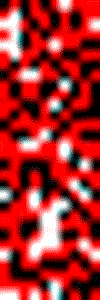

In [25]:
import PIL.Image, PIL
from io import BytesIO
import IPython.display
import numpy as np

#TODO gif
def show_img_array(a, fmt='png', width=50):
    a = np.uint8(a)
    f = BytesIO()
    img = PIL.Image.fromarray(a)
    wpercent = (width/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((width,hsize), PIL.Image.ANTIALIAS)
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

    

def show_gif_array(a, width=50):
    a = np.uint8(a)
    f = BytesIO()
    images = list()
    for aframe in a:
        img = PIL.Image.fromarray(aframe)
        wpercent = (width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((width,hsize), PIL.Image.ANTIALIAS)
        images.append(img)
        
    img = images[0]
    img.save(f, 'gif', save_all=True, append_images=images[1:], loop=255)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

c_white = 255, 255, 255
c_black = 0,0,0
c_red = 255,0,0
print(len(passports))
migration_frames = list()
for tick in passports:
    migration_frame = np.empty((*world_shape, 3), dtype='uint8')
    migration_frame[:] = c_white
    for point, parents in tick.items():
        migration_frame[point] = c_black
        for parent in parents:
            migration_frame[parent] = c_red
    migration_frames.append(migration_frame)
show_gif_array(migration_frames, width=100)


# Turnover chart

Each cell counts # of deaths, => color gradient

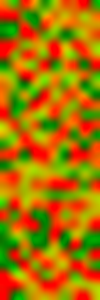

In [26]:
from colour import Color


turnover_map = np.zeros(world_shape, dtype='uint8')
for tick in passports:
    for point, parents in tick.items():
        turnover_map[point] += 1
max_turnover = np.max(turnover_map)
color_gradient = list(Color("red").range_to(Color("green"), max_turnover))

turnover_frame = np.zeros((*world_shape, 3), dtype='uint8')
for i in range(turnover_map.size):
    j = i*3
    c = color_gradient[turnover_map.take(i)-1]
    pixel = (np.array(c.rgb)*255).astype('uint8')
    turnover_frame.put([j, j+1, j+2], pixel)
        
show_img_array(turnover_frame, width=100)


# Tracking OC

Number each cell. On Reproduction cell set is of contributing cell sets.

# Family Tree

http://scikit-bio.org/docs/0.4.1/tree.html
